# 1. Set Up

In [1]:
import math
import os
import re
import sys
import time
import json
from pathlib import Path
import subprocess
import zipfile
import pydantic
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyvista as pv
import gmsh

sys.path.append('/mofem_install/jupyter/thomas/mfront_example_test/src')

import setup
import core
import custom_models as cm
import utils as ut
import plotting
import calculations as calc
import pyvista as pv
    
import matplotlib
matplotlib.rc('figure', figsize=(7, 7))


In [2]:
#in MPa
def initialize_parameters(custom_mesh_filepath: str, global_default_model: cm.PropertyTypeEnum) -> cm.AttrDict:
    params = cm.AttrDict()
    params.interface = False
    params.global_default_model = global_default_model
    params.pile_manager = cm.PileManager(x=0, y=0, z=0, dx=0, dy=0, R=1, r=0.975,
                                         stickup_height = 10,
                                         embedded_depth = -10.5,
                                preferred_model= cm.PropertyTypeEnum.le,
                                props = {
                                    cm.PropertyTypeEnum.le: cm.ElasticProperties(youngs_modulus=200000, poisson_ratio=0.3),
                                },
                                interface = params.interface,
                                )

    soil_layer_1 = cm.SoilLayer(
        depth = -2,
        preferred_model= params.global_default_model,
        props = {
            cm.PropertyTypeEnum.le: cm.ElasticProperties(youngs_modulus=96, poisson_ratio=0.499),
            cm.PropertyTypeEnum.vM: cm.VonMisesProperties(youngs_modulus=96, poisson_ratio=0.499,HardeningSlope = 10, YieldStress = 5),
            cm.PropertyTypeEnum.dp: cm.DruckerPragerProperties(youngs_modulus=96, poisson_ratio=0.499, phi=np.radians(27), c=0.1, v=np.radians(27)),
            cm.PropertyTypeEnum.mcc: cm.CamClayProperties(),
            }, 
            )
    soil_layer_2 = cm.SoilLayer(
        depth = -1.4,
        preferred_model= params.global_default_model,
        props = {
            cm.PropertyTypeEnum.le: cm.ElasticProperties(youngs_modulus=182.1, poisson_ratio=0.499),
            cm.PropertyTypeEnum.vM: cm.VonMisesProperties(youngs_modulus=182.1, poisson_ratio=0.499,HardeningSlope = 10, YieldStress = 5),
            cm.PropertyTypeEnum.dp: cm.DruckerPragerProperties(youngs_modulus=182.1, poisson_ratio=0.499, phi=np.radians(27), c=0.1, v=np.radians(27)),
            cm.PropertyTypeEnum.mcc: cm.CamClayProperties(),
            }, 
            )
    soil_layer_3 = cm.SoilLayer(
        depth = -7.1,
        preferred_model= params.global_default_model,
        props = {
            cm.PropertyTypeEnum.le: cm.ElasticProperties(youngs_modulus=351.3, poisson_ratio=0.499),
            cm.PropertyTypeEnum.vM: cm.VonMisesProperties(youngs_modulus=351.3, poisson_ratio=0.499,HardeningSlope = 10, YieldStress = 5),
            cm.PropertyTypeEnum.dp: cm.DruckerPragerProperties(youngs_modulus=351.3, poisson_ratio=0.499, phi=np.radians(27), c=0.1, v=np.radians(27)),
            cm.PropertyTypeEnum.mcc: cm.CamClayProperties(),
                 }, 
            )
    soil_layer_4 = cm.SoilLayer(
        depth = -29.5,
        preferred_model= params.global_default_model,
        props = {
            cm.PropertyTypeEnum.le: cm.ElasticProperties(youngs_modulus=668.4, poisson_ratio=0.499),
            cm.PropertyTypeEnum.vM: cm.VonMisesProperties(youngs_modulus=668.4, poisson_ratio=0.499,HardeningSlope = 10, YieldStress = 5),
            cm.PropertyTypeEnum.dp: cm.DruckerPragerProperties(youngs_modulus=668.4, poisson_ratio=0.499, phi=np.radians(27), c=0.1, v=np.radians(27)),
            cm.PropertyTypeEnum.mcc: cm.CamClayProperties(),
            }, 
            )
    params.interface_manager = cm.InterfaceManager(
        preferred_model = cm.PropertyTypeEnum.vM,
        props = {
            cm.PropertyTypeEnum.le: cm.ElasticProperties(youngs_modulus=96, poisson_ratio=0.3),
            cm.PropertyTypeEnum.vM: cm.VonMisesProperties(youngs_modulus=96, poisson_ratio=0.499,HardeningSlope = 5000, YieldStress = 20),
            cm.PropertyTypeEnum.dp: cm.DruckerPragerProperties(youngs_modulus=668.4, poisson_ratio=0.499, phi=np.radians(27), c=0, v=np.radians(27)),
            },
            )
    # params.prescribed_force = cm.ForceBoundaryCondition(fx=0,fy=0,fz=0)
    params.prescribed_disp = cm.SurfaceBoundaryCondition(disp_ux=1, disp_uy=0 ,disp_uz=0)
    params.box_manager = cm.BoxManager(x=-80, y=-80, z=0, dx=160, dy=80,
        layers=[
        soil_layer_1,
        soil_layer_2,
        soil_layer_3,
        soil_layer_4,   
        ],
        far_field_size=5,
        near_field_dist=5,
        near_field_size=0.05,
    )
    params.cylinder_manager = cm.CylinderManager(
        x=0, 
        y=0, 
        z=0, 
        dx=0, 
        dy=0, 
        r=80,
        pile_R = params.pile_manager.R,
        pile_r = params.pile_manager.r,
        layers=[
        soil_layer_1,
        soil_layer_2,
        soil_layer_3,
        soil_layer_4,   
        ],
        far_field_size=5,
        near_field_dist=5,
        near_field_size=0.05,
        radial_progression = 1.3,
    )
    params.mesh_radial_divisions = 10
    params.nproc = 8 # number of processors/cores used
    params.order = 2 #order of approximation functions
    params.dim = 3
    
    params.final_time = 1 # [s]
    params.time_step = 1 / 200 # [s]
    params.provided_mesh = custom_mesh_filepath
    
    def custom_generate_physical_groups(params) -> list[cm.PhysicalGroup]:
        physical_group_list = [
            cm.PhysicalGroup(
                meshnet_id=1,
                name="MFRONT_MAT_1",
                preferred_model=params.cylinder_manager.layers[0].preferred_model,
                props=params.cylinder_manager.layers[0].props,
                ),
            cm.PhysicalGroup(
                meshnet_id=2,
                name="MFRONT_MAT_2",
                preferred_model=params.cylinder_manager.layers[1].preferred_model,
                props=params.cylinder_manager.layers[1].props,
                ),
            cm.PhysicalGroup(
                meshnet_id=3,
                name="MFRONT_MAT_3",
                preferred_model=params.cylinder_manager.layers[2].preferred_model,
                props=params.cylinder_manager.layers[2].props,
                ),
            cm.PhysicalGroup(
                meshnet_id=4,
                name="MFRONT_MAT_4",
                preferred_model=params.cylinder_manager.layers[3].preferred_model,
                props=params.cylinder_manager.layers[3].props,
                ),
            cm.PhysicalGroup(
                meshnet_id=5,
                name="MFRONT_MAT_5",
                preferred_model=params.pile_manager.preferred_model,
                props=params.pile_manager.props,
                ),
        ]
        return physical_group_list
    
    if getattr(params, "provided_mesh", False):
        try:
            params.custom_generate_physical_groups = custom_generate_physical_groups
        except NameError as e:
            raise NameError("Must provided the custom callback 'custom_generate_physical_groups' to inject attributes to the main commmand.")
             
        
    params.case_name = "pile"
    params.base = "hex"
    params.wk_dir = Path(f"/mofem_install/jupyter/thomas/mfront_example_test")
    params.read_med_exe = "/mofem_install/jupyter/thomas/um_view/bin/read_med"
    params.h5m_to_vtk_converter = "/mofem_install/jupyter/thomas/um_view/bin/convert.py"
    params.partition_exe = "/mofem_install/jupyter/thomas/um_view/bin/mofem_part"
    params.exe = f"/mofem_install/jupyter/thomas/um_view/tutorials/adv-1/contact_3d"
    params.paraview_path = "/mofem_install/jupyter/thomas/ParaView-5.13.1-MPI-Linux-Python3.10-x86_64/bin/pvpython"
    params.ffmpeg_path = '/mofem_install/jupyter/thomas/ffmpeg-7.0.2-amd64-static/ffmpeg',
    
    params.mode = "auto" # see 4. to see difference between auto and manual

    return params

In [3]:
def quick_visualization(params):
    pv.set_plot_theme("document")

    from pyvirtualdisplay import Display
    display = Display(backend="xvfb", visible=False, size=(1024, 768))
    display.start()
    vtk_files = subprocess.run(f"ls -c1 {params.vtk_dir}/*.vtk | sort -V", shell=True, text=True, capture_output=True)
    if vtk_files.returncode == 0:
        files = [vtk_file for vtk_file in vtk_files.stdout.splitlines()]
        final_file = files[-1]
        mesh = pv.read(final_file)
        mesh=mesh.shrink(0.95) 
        warp_factor = 1.0
        # mesh = mesh.warp_by_vector(vectors="U", factor = warp_factor)
        # show_field = "STRESS"
        show_field = "STRAIN" # U: displacement
        # show_field = "STRAIN" # U: displacement
        # print(mesh.point_data)
        # if mesh.point_data[show_field].shape[1] > 3:
            # cmap = "Spectral"
        p = pv.Plotter(notebook=True)
        p.add_mesh(mesh, scalars=show_field)
        # p.camera_position = [(-10, 0, 10), (0.0, 0.0, 0.0), (0.0, 1.0, 0.0)]
        p.camera_position = 'xz'
        p.show(jupyter_backend='ipygany')

In [4]:
points_of_interest = [
        cm.Point(x=-1,y=0,z=10),
        cm.Point(x=-1,y=0,z=0),
        cm.Point(x=-1,y=0,z=-10.5),
    ]
line_of_interest = cm.Line(pt1=cm.Point(x=-1,y=0,z=10), pt2=cm.Point(x=-1,y=0,z=-40),)
def postprocessing(params):
    original_pythonpath = os.environ.get("PYTHONPATH", "")
    os.environ["PYTHONPATH"] = ""

    
    @ut.track_time("PULLING A SELECTED POINT OVER TIME WITH pvpython")
    def point_to_csv(params, point: cm.Point):
        command = [
            params.paraview_path,
            "/mofem_install/jupyter/thomas/mfront_example_test/src/pvpython_scripts/point_to_time_csv.py",
            params.vtk_dir,
            point.point_against_time_csv_filepath(params),
            *point.flat(),
        ]
        # Run the command using subprocess
        process = subprocess.run(command, check=True, capture_output=True)
    @ut.track_time("PULLING A SELECTED LINE OVER DEPTH AT THE FINAL TIMESTEP WITH pvpython")
    def line_to_csv(params, line: cm.Line):
        command = [
            params.paraview_path,
            "/mofem_install/jupyter/thomas/mfront_example_test/src/pvpython_scripts/line_to_depth_csv.py",
            params.vtk_dir,
            line.line_against_depth_csv_filepath(params),
            *line.pt1.flat(),
            *line.pt2.flat(),
        ]
        # Run the command using subprocess
        process = subprocess.run(command, check=True, capture_output=True)



    @ut.track_time("ANIMATING OVER TIME WITH pvpython")
    def animate(params, color_min, color_max):
        command = [
            params.paraview_path,
            "/mofem_install/jupyter/thomas/mfront_example_test/src/pvpython_scripts/pile_animate.py",
            params.vtk_dir,
            params.strain_animation_filepath_png,
            str(color_min),
            str(color_max),
        ]
        # Run the command using subprocess
        try:
            process = subprocess.run(command, check=True, capture_output=True)
        except subprocess.CalledProcessError as e:
            print("An error occurred:", e.stderr.decode())
        finally:
        # Restore the original PYTHONPATH
            os.environ["PYTHONPATH"] = original_pythonpath

    #Stitch together animations
    @ut.track_time("STITCHING .pngs TOGETHER with ffmpeg")
    def create_mp4_from_png_sequence(animation_filepath_png_ffmpeg_regex, animation_filepath_mp4, framerate=40):
        # Build the ffmpeg command
        ffmpeg_command = [
            params.ffmpeg_path,
            '-framerate', str(framerate),  # Set input framerate
            '-y',
            '-i', animation_filepath_png_ffmpeg_regex,  # Input image sequence (with regex pattern)
            '-c:v', 'libx264',  # Set video codec to libx264
            '-pix_fmt', 'yuv420p',  # Set pixel format for compatibility
            '-loglevel', 'warning',
            animation_filepath_mp4  # Output .mp4 file
        ]

        # Run the ffmpeg command as a subprocess
        try:
            subprocess.run(ffmpeg_command, check=True, capture_output=True)
            print(f"MP4 video created successfully: {animation_filepath_mp4}")
        except subprocess.CalledProcessError as e:
            print(f"Error occurred during ffmpeg execution: {e}")
        except Exception as e:
            print(f"An unexpected error occurred: {e}")
    try:
        for point in points_of_interest:
            point_to_csv(params, point)
        line_to_csv(params, line_of_interest)
    except subprocess.CalledProcessError as e:
        print("An error occurred:", e.stderr.decode())
    finally:
        # Restore the original PYTHONPATH
        os.environ["PYTHONPATH"] = original_pythonpath
    # df = pd.read_csv(points_of_interest[0].point_against_time_csv_filepath(params))
    # strain_magnitude = np.array(df['avg(STRAIN (Magnitude))'])
    # color_max = strain_magnitude.max()
    # color_min = strain_magnitude.min()
    # animate(params, color_min, color_max)
    # create_mp4_from_png_sequence(params.strain_animation_filepath_png_ffmpeg_regex, params.strain_animation_filepath_mp4, framerate=40)


In [5]:
def plot_all(params):

    df = pd.read_csv(line_of_interest.line_against_depth_csv_filepath(params))
    df = df.dropna()
    x = np.array(df['Points:0'])
    y = np.array(df['Points:1'])
    z = np.array(df['Points:2'])
    disp_x = np.array(df['DISPLACEMENT:0'])
    disp_y = np.array(df['DISPLACEMENT:1'])
    disp_z = np.array(df['DISPLACEMENT:2'])
    sig_xx = np.array(df['STRESS:0'])
    sig_xy = np.array(df['STRESS:1'])
    sig_xz = np.array(df['STRESS:2'])
    sig_yy = np.array(df['STRESS:4'])
    sig_yz = np.array(df['STRESS:5'])
    sig_zz = np.array(df['STRESS:8'])
    e_xx = np.array(df['STRAIN:0'])
    e_xy = np.array(df['STRAIN:1'])
    e_xz = np.array(df['STRAIN:2'])
    e_yy = np.array(df['STRAIN:4'])
    e_yz = np.array(df['STRAIN:5'])
    e_zz = np.array(df['STRAIN:8'])
    sig_1, sig_2, sig_3 = calc.calculate_principal_stresses(sig_xx, sig_yy, sig_zz, sig_xy, sig_xz, sig_yz)
    p = calc.calculate_p(sig_1, sig_2, sig_3)
    J_2 = calc.calculate_J2(sig_1, sig_2, sig_3)
    J  = np.sqrt(J_2)
    tau_oct = np.sqrt(2 * J_2)
    sig_eq = np.sqrt(3 * J_2)
    e_v, e_d = calc.calculate_volumetric_and_deviatoric_strain(e_xx, e_yy, e_zz, e_xy, e_xz, e_yz)
    graph_dir = line_of_interest.graph_dir(params)
    plotting.plot_x_ys(disp_x, [z], labels=["FEA"], x_label='$\mu_x$ [m]', y_label='Depth [m]', title='Depth vs $\mu_x$', save_as = f"{graph_dir}/401_z_ux.png")

    for point in points_of_interest:
        graph_dir = point.graph_dir(params)
        df = pd.read_csv(points_of_interest[0].point_against_time_csv_filepath(params))
        sig_xx = np.array(df['avg(STRESS (0))'])
        sig_xy = np.array(df['avg(STRESS (1))'])
        sig_xz = np.array(df['avg(STRESS (2))'])
        sig_yy = np.array(df['avg(STRESS (4))'])
        sig_yz = np.array(df['avg(STRESS (5))'])
        sig_zz = np.array(df['avg(STRESS (8))'])

        e_xx = np.array(df['avg(STRAIN (0))'])
        e_xy = np.array(df['avg(STRAIN (1))'])
        e_xz = np.array(df['avg(STRAIN (2))'])
        e_yy = np.array(df['avg(STRAIN (4))'])
        e_yz = np.array(df['avg(STRAIN (5))'])
        e_zz = np.array(df['avg(STRAIN (8))'])

        sig_1, sig_2, sig_3 = calc.calculate_principal_stresses(sig_xx, sig_yy, sig_zz, sig_xy, sig_xz, sig_yz)
        p = calc.calculate_p(sig_1, sig_2, sig_3)
        J_2 = calc.calculate_J2(sig_1, sig_2, sig_3)
        J  = np.sqrt(J_2)
        tau_oct = np.sqrt(2 * J_2)
        sig_eq = np.sqrt(3 * J_2)
        e_v, e_d = calc.calculate_volumetric_and_deviatoric_strain(e_xx, e_yy, e_zz, e_xy, e_xz, e_yz)

        
        # print(f"exx: {e_xx[-1]}")
        # print(f"eyy: {e_yy[-1]}")
        # print(f"ezz: {e_zz[-1]}")
        # print(f"sig1: {sig_1[-1]}")
        # print(f"sig2: {sig_2[-1]}")
        # print(f"sig3: {sig_3[-1]}")
        # print(f"p: {p[-1]}")
        # print(f"J2: {J_2[-1]}")
        # print(f"J: {J[-1]}")
        # print(f"sig_eq: {sig_eq[-1]}")
        label = f"""{params.global_default_model.value} (FEA) 
        at {point.string()}"""
        plotting.plot_x_ys(p, [sig_eq], labels=[label], x_label='Hydrostatic stress $p$', y_label='Equivalent stress $sig_{eq}$', title='Equivalent Stress vs Hydrostatic stress', save_as = f"{graph_dir}/111_sigeq_p.png")

        plotting.plot_x_ys(e_zz, [sig_eq], labels=[label], x_label='Axial Strain $\epsilon_{zz}$', y_label='Equivalent Stress $\sigma_{eq}$', title='Equivalent Stress $\sigma_{eq}$ vs Axial Strain $\epsilon_{zz}$', save_as = f"{params.graph_dir}/201_sigeq_eyy.png")
        plotting.plot_x_ys(e_zz, [sig_zz], labels=["test1"], x_label='Axial Strain $\epsilon_{zz}$', y_label='Stress $\sigma_{zz}$', title='Stress $\sigma_{zz}$ vs Axial Strain $\epsilon_{zz}$', save_as = f"{graph_dir}/201_sigeq_ezz.png")
        plotting.plot_x_ys(e_zz, [sig_yy], labels=["test1"], x_label='Axial Strain $\epsilon_{zz}$', y_label='Stress $\sigma_{yy}$', title='Stress $\sigma_{yy}$ vs Axial Strain $\epsilon_{zz}$', save_as = f"{graph_dir}/201_sigeq_eyy.png")
        plotting.plot_x_ys(e_zz, [sig_xx], labels=["test1"], x_label='Axial Strain $\epsilon_{zz}$', y_label='Stress $\sigma_{xx}$', title='Stress $\sigma_{xx}$ vs Axial Strain $\epsilon_{zz}$', save_as = f"{graph_dir}/201_sigeq_exx.png")

        plotting.plot_x_ys(e_zz[1:], [sig_eq[1:]/p[1:]], labels=["test1"], x_label='Axial Strain $\epsilon_{yy}$', y_label='Stress ratio $q/p$', title='Stress ratio vs Axial Strain', save_as = f"{graph_dir}/211_sigeq_div_p_eyy.png")

        plotting.plot_x_ys(e_d, [e_v], labels=["volumetric - axial"], x_label='Axial strain $\epsilon_{zz}$', y_label='Volumetric strain $\epsilon^v$', title='Volumetric strain vs Axial strain', save_as = f"{graph_dir}/302_ev_ed.png")
        plotting.plot_x_ys(e_d, [e_d], labels=["Deviatoric - axial"], x_label='Axial strain $\epsilon_{zz}$', y_label='Deviatoric strain $\epsilon^v$', title='Deviatoric strain vs Axial strain', save_as = f"{graph_dir}/303_ev_ed.png")
        plotting.plot_x_ys(e_d, [e_v], labels=["FEA"], x_label='Deviatoric strain $\epsilon^d$', y_label='Volumetric strain $\epsilon^v$', title='Volumetric strain vs Deviatoric strain', save_as = f"{graph_dir}/304_ev_ed.png")

In [ ]:
meshes = [
    "/mofem_install/jupyter/thomas/mfront_example_test/user_data/save_test_1.cub",
    "/mofem_install/jupyter/thomas/mfront_example_test/user_data/save_test_2.cub",
    "/mofem_install/jupyter/thomas/mfront_example_test/user_data/save_test_3.cub",
    "/mofem_install/jupyter/thomas/mfront_example_test/user_data/save_test_4.cub",
    "/mofem_install/jupyter/thomas/mfront_example_test/user_data/save_test_5.cub",
    "/mofem_install/jupyter/thomas/mfront_example_test/user_data/save_test_6.cub",
    "/mofem_install/jupyter/thomas/mfront_example_test/user_data/save_test_7.cub",
    "/mofem_install/jupyter/thomas/mfront_example_test/user_data/save_test_8.cub",
    "/mofem_install/jupyter/thomas/mfront_example_test/user_data/save_test_9.cub",
    "/mofem_install/jupyter/thomas/mfront_example_test/user_data/save_test_10.cub",
]
soil_model = cm.PropertyTypeEnum.le

bulk_dir = Path(f"/mofem_install/jupyter/thomas/mfront_example_test/simulations/bulk_{soil_model.value}")
bulk_dir.mkdir(parents=True, exist_ok=True)


bulk_log = bulk_dir / "pile_bulk.log"

with open(bulk_log, 'w'): pass
parameters = {}
for i, mesh in enumerate(meshes):
    params = initialize_parameters(custom_mesh_filepath=mesh, global_default_model=soil_model) # 2. Simulation Parameters
    params = setup.setup(params) # 3. Log paths and meta
    core.generate_mesh(params) # 4. Generate the mesh
    core.mofem_compute(params) # 5. Running the analysis and export to .vtk file format
    core.export_to_vtk(params)
    # quick_visualization(params) # 6. Visualize final time step .vtk file
    postprocessing(params) # 7. Extract data from .vtk files 
    plot_all(params) # 8. Plotting
    # parameters.append(params)
    props = cm.BulkAnalysisProps(
        data_dir = params.data_dir,
        mesh_name_appended = params.mesh_name_appended,
        total_force_log_file = params.total_force_log_file,
        FIX_X_1_force_log_file = params.FIX_X_1_force_log_file,
        DOFs_log_file =  params.DOFs_log_file,
        ux_log_file= params.ux_log_file,
    )
    parameters[f"{i}"] = props.model_dump_json(indent=2)
with open(bulk_log, 'w') as f:
    json.dump(parameters, f, indent=2)





Simulation #11 for the day.
╭─────────────────────────────────────╮
│  PARTITIONING MESH with mofem_part  │
╰─────────────────────────────────────╯
Done, taken Wall Time: 0.73 seconds, CPU Time: 0.00 seconds
╭─────────────╮
│  COMPUTING  │
╰─────────────╯
[0] <inform> MoFEM version 0.14.0 (MOAB 5.5.0 Petsc Release Version 3.16.6, Mar 30, 2022 )
[0] <inform> git commit id 693a01d8ad1e79f10b1dc4f1dd785f311161b1d1
[0] <inform> Local time: 2024-11-19 16:30:28
[0] <inform> UTC time: 2024-11-19 16:30:28
[0] <warning> [MeshsetMng] broadcasted vertex 3280 has negative id
[0] <warning> [MeshsetMng] broadcasted vertex 3281 has negative id
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316814 type BLOCKSET UNKNOWNNAME msId 1 name MFRONT_MAT_1 block header:  blockCol = 0 blockMat = 0 blockDimension = 3
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316815 type BLOCKSET UNKNOWNNAME msId 2 name MFRONT_MAT_2 block header:  blockCol = 0 blockMat = 0 blockDimen

{'0': '{\n  "data_dir": "/mofem_install/jupyter/thomas/mfront_example_test/simulations/pile_day_94_sim_1_20241119_155249_le",\n  "mesh_name_appended": "pile_day_94_sim_1_le",\n  "total_force_log_file": "/mofem_install/jupyter/thomas/mfront_example_test/simulations/pile_day_94_sim_1_20241119_155249_le/result_pile_day_94_sim_1_le_total_force.log",\n  "FIX_X_1_force_log_file": "/mofem_install/jupyter/thomas/mfront_example_test/simulations/pile_day_94_sim_1_20241119_155249_le/result_pile_day_94_sim_1_le_FIX_X_1_force.log",\n  "DOFs_log_file": "/mofem_install/jupyter/thomas/mfront_example_test/simulations/pile_day_94_sim_1_20241119_155249_le/result_pile_day_94_sim_1_le_DOFs.log",\n  "ux_log_file": "/mofem_install/jupyter/thomas/mfront_example_test/simulations/pile_day_94_sim_1_20241119_155249_le/result_pile_day_94_sim_1_le_ux.log"\n}', '1': '{\n  "data_dir": "/mofem_install/jupyter/thomas/mfront_example_test/simulations/pile_day_94_sim_2_20241119_155424_le",\n  "mesh_name_appended": "pile_d

/mofem_install/jupyter/thomas/mfront_example_test/src/plotting.py:324: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


'/mofem_install/jupyter/thomas/mfront_example_test/simulations/bulk_LinearElasticity/graphs/004_Displacement_DOFs.png'

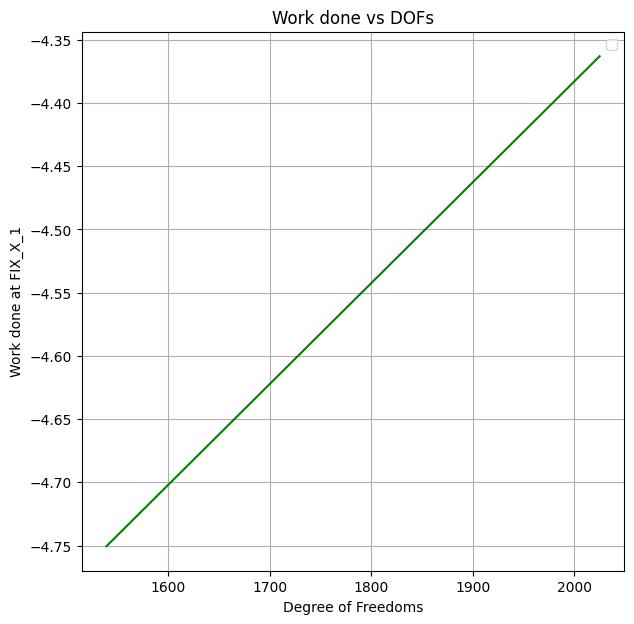

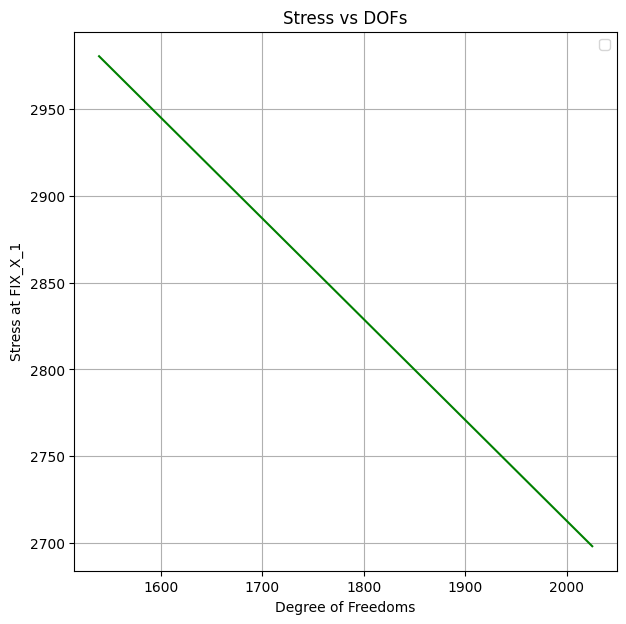

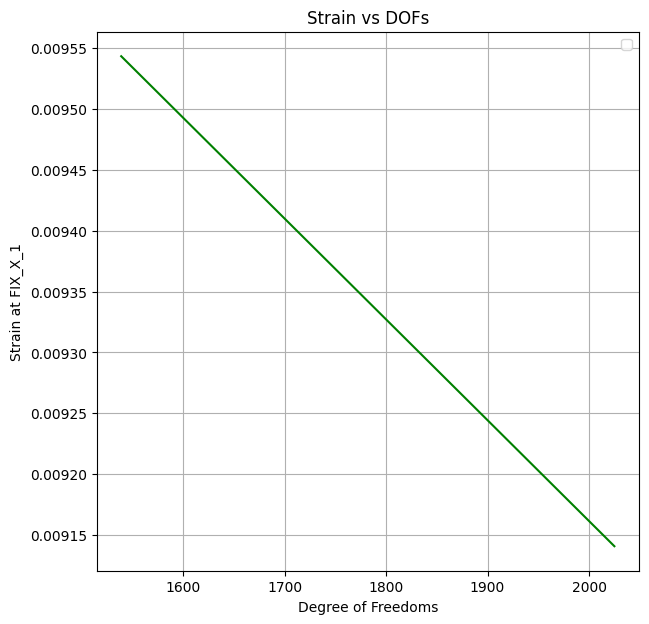

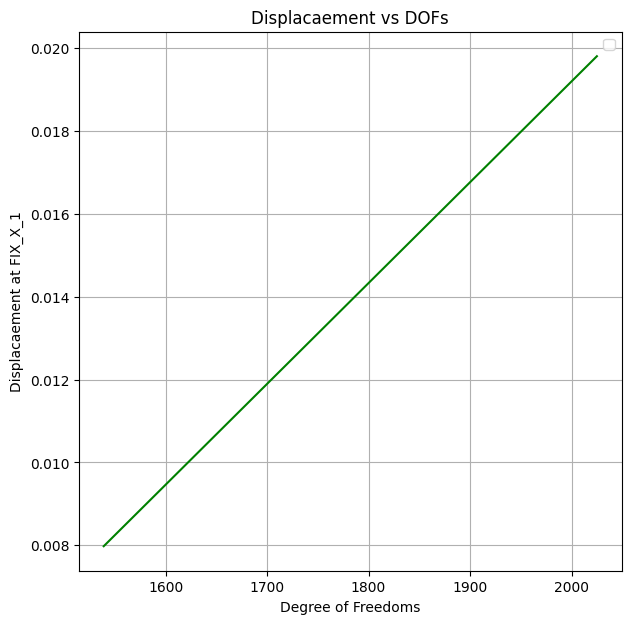

In [ ]:
from pathlib import Path
import os
import json
import sys

import pydantic
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append('/mofem_install/jupyter/thomas/mfront_example_test/src')

import custom_models as cm
import plotting

soil_model = cm.PropertyTypeEnum.le
bulk_dir = Path(f"/mofem_install/jupyter/thomas/mfront_example_test/simulations/bulk_{soil_model.value}")
bulk_log = bulk_dir / "pile_bulk.log"

if os.path.exists(bulk_log):
    with open(bulk_log, 'r') as f:
        logs = json.load(f)
        print(logs)
else:
    raise FileNotFoundError("The bulk log is not found. Possibly because this bulk analysis was not performed yet?")

bulk_graph_dir = bulk_dir / "graphs"
bulk_graph_dir.mkdir(parents=True, exist_ok=True)
bulk_csv = bulk_dir / "pile_bulk.csv"

DOFs = [] # number of DOFs
FIX_1_strain_energies = [] # values of energy

df = {
    "DOFs": [],
    "FIX_1_WD": [],
    "final_stress": [],
    "final_strain": [],
    "final_disp": [],
}

for i, log in logs.items():
    params = cm.BulkAnalysisProps.parse_raw(log)
    data_poi_mudline=pd.read_csv(points_of_interest[1].point_against_time_csv_filepath(params))
    data_tot_force=pd.read_csv(params.total_force_log_file,sep='\s+',header=None)
    data_force=pd.read_csv(params.FIX_X_1_force_log_file,sep='\s+',header=None)
    data_dofs=pd.read_csv(params.DOFs_log_file,sep='\s+',header=None)
    data_ux=pd.read_csv(params.ux_log_file,sep='\s+',header=None)
    final_stress = data_poi_mudline["avg(STRESS (Magnitude))"].iloc[-1]
    final_strain = data_poi_mudline["avg(STRAIN (Magnitude))"].iloc[-1]
    final_disp = data_poi_mudline["avg(DISPLACEMENT (Magnitude))"].iloc[-1]
    DOF = data_dofs[15][0]
    
    ux_values = data_ux[5]  # Assuming the 5th column (index 4) contains ux values
    ux_increments = np.diff(ux_values)  # Compute differences between consecutive ux values (199 increments)
    # Compute corresponding force values (ignoring the first force for integration purposes)
    force_values = data_force[4][1:].values  # Assuming the 5th column (index 4) contains force values from index 1 onward
    # Perform numerical integration: sum(force * increment) * 0.5
    FIX_1_WD = 0.5 * np.sum(force_values * ux_increments)  

    df["DOFs"].append(DOF)
    df["FIX_1_WD"].append(FIX_1_WD)
    df["final_stress"] .append(final_stress)
    df["final_strain"] .append(final_strain)
    df["final_disp"] .append(final_disp)

df = pd.DataFrame(df)

df.to_csv(bulk_csv)
plotting.plot_x_ys(df["DOFs"], [df["FIX_1_WD"]], labels=[""], x_label='Degree of Freedoms', y_label='Work done at FIX_X_1', title='Work done vs DOFs', save_as = f"{bulk_graph_dir}/001_Work_done_DOFs.png", show=True)
plotting.plot_x_ys(df["DOFs"], [df["final_stress"]], labels=[""], x_label='Degree of Freedoms', y_label='Stress at FIX_X_1', title='Stress vs DOFs', save_as = f"{bulk_graph_dir}/002_Stress_DOFs.png", show=True)
plotting.plot_x_ys(df["DOFs"], [df["final_strain"]], labels=[""], x_label='Degree of Freedoms', y_label='Strain at FIX_X_1', title='Strain vs DOFs', save_as = f"{bulk_graph_dir}/003_Strain_DOFs.png", show=True)
plotting.plot_x_ys(df["DOFs"], [df["final_disp"]], labels=[""], x_label='Degree of Freedoms', y_label='Displacaement at FIX_X_1', title='Displacaement vs DOFs', save_as = f"{bulk_graph_dir}/004_Displacement_DOFs.png", show=True)